In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import os


image_dir = 'dataset/compiled/images'
labels_dir = 'dataset/compiled/labels'
image_extensions = ('.jpeg', '.jpg', '.png', '.bmp')

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU available:", tf.config.list_physical_devices('GPU'))

In [ ]:
import cv2 # computer vision module
import imghdr # allow to check for file extension for particular image

image_dir = 'dataset/compiled/images'
labels_dir = 'dataset/compiled/labels'

heights = []
widths = []
image_extensions = ('.jpeg', '.jpg', '.png', '.bmp')
min_height, min_width = float('inf'), float('inf')

# Iterate through all image files
for file_name in os.listdir(image_dir):
    if file_name.lower().endswith(image_extensions):
        image_path = os.path.join(image_dir, file_name)
        img = cv2.imread(image_path)

        if img is not None:
            height, width = img.shape[:2]
            heights.append(height)
            widths.append(width)
            min_height = min(min_height, height)
            min_width = min(min_width, width)

print(f"Smallest Image Dimensions: Height = {min_height}, Width = {min_width}")

# Plot dimension distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(heights, bins=30, color='skyblue', edgecolor='black')
plt.title('Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(widths, bins=30, color='lightgreen', edgecolor='black')
plt.title('Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [ ]:
from collections import Counter

class_counts = Counter()

# Process all label files
for label_file in os.listdir(labels_dir):
    if label_file.endswith('.txt'):
        with open(os.path.join(labels_dir, label_file), 'r') as f:
            for line in f:
                parts = line.strip().split()
                if parts:
                    class_id = int(parts[0])
                    class_counts[class_id] += 1

# Print raw counts
print("Class distribution (raw counts):")
for class_id in sorted(class_counts):
    print(f"Class {class_id}: {class_counts[class_id]}")

# Visualize with a bar plot
labels = ['First Degree (0)', 'Second Degree (1)', 'Third Degree (2)']
counts = [class_counts.get(i, 0) for i in range(3)]

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=['skyblue', 'orange', 'red'])
plt.title("Burn Severity Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Instances")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
import os
import cv2
import imghdr
from collections import Counter


channel_stats = Counter()
problem_files = []

# Loop through images
for file_name in os.listdir(image_dir):
    if file_name.lower().endswith(image_extensions):
        file_path = os.path.join(image_dir, file_name)

        # Validate image type
        if imghdr.what(file_path) is None:
            problem_files.append((file_name, "Not a valid image"))
            continue

        img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

        if img is None:
            problem_files.append((file_name, "cv2 failed to load"))
            continue

        # Check channel shape
        if len(img.shape) == 2:
            # Grayscale image
            channel_stats['grayscale'] += 1
        elif len(img.shape) == 3:
            channels = img.shape[2]
            if channels == 3:
                channel_stats['RGB'] += 1
            elif channels == 4:
                channel_stats['RGBA'] += 1
            else:
                channel_stats[f'{channels}-channel'] += 1
                problem_files.append((file_name, f"Unusual {channels} channels"))
        else:
            problem_files.append((file_name, "Unknown shape"))

# Output the stats
print("\nImage Channel Distribution:")
for k, v in channel_stats.items():
    print(f"{k}: {v}")

if problem_files:
    print(f"\n Found {len(problem_files)} problematic images:")
    for file, reason in problem_files[:10]:  # show only first 10
        print(f" - {file}: {reason}")
else:
    print("\n All images passed channel checks. No grayscale, RGBA, or malformed images were found.")

In [ ]:
import matplotlib.image as mpimg

# Display sample images
image_files = os.listdir(image_dir)
print(f"Total number of images: {len(image_files)}")

def display_sample_images(n_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(n_samples):
        img_path = os.path.join(image_dir, image_files[i])
        img = mpimg.imread(img_path)

        plt.subplot(1, n_samples, i+1)
        plt.imshow(img)
        plt.title(f"{image_files[i]}\n{img.shape}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_sample_images()

In [ ]:
#1.2 labels
from collections import defaultdict


# Basic Statistics
label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]
print(f"Total label files: {len(label_files)}")

# Analyze class distribution and bounding box characteristics
class_counts = defaultdict(int)
all_boxes = []
all_wh_ratios = []

for label_file in label_files:
    with open(os.path.join(labels_dir, label_file), 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 5:  # Ensure valid line
                class_id, x, y, w, h = map(float, parts)
                class_counts[int(class_id)] += 1
                all_boxes.append([x, y, w, h])
                all_wh_ratios.append(w/h)

# Convert to numpy for easier calculations
all_boxes = np.array(all_boxes)
all_wh_ratios = np.array(all_wh_ratios)

# 3. Print statistics
print("\nClass Distribution:")
for class_id, count in sorted(class_counts.items()):
    print(f"Class {class_id}: {count} instances ({count/len(all_boxes)*100:.1f}%)")

print("\nBounding Box Statistics:")
print(f"Total objects: {len(all_boxes)}")
print(f"Average width: {all_boxes[:,2].mean():.4f}")
print(f"Average height: {all_boxes[:,3].mean():.4f}")
print(f"Average aspect ratio (w/h): {all_wh_ratios.mean():.4f}")
print(f"Min width: {all_boxes[:,2].min():.4f}, Max width: {all_boxes[:,2].max():.4f}")
print(f"Min height: {all_boxes[:,3].min():.4f}, Max height: {all_boxes[:,3].max():.4f}")

In [ ]:
# Visualization
def plot_class_distribution(class_counts):
    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Class ID')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()

def plot_box_size_distribution(boxes):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(boxes[:,2], bins=50)
    plt.xlabel('Normalized Width')
    plt.title('Width Distribution')

    plt.subplot(1, 2, 2)
    plt.hist(boxes[:,3], bins=50)
    plt.xlabel('Normalized Height')
    plt.title('Height Distribution')
    plt.tight_layout()
    plt.show()

plot_class_distribution(class_counts)
plot_box_size_distribution(all_boxes)


In [ ]:
import os

### Data Cleaning
# Get base filenames without extensions
image_files = {os.path.splitext(f)[0] for f in os.listdir(image_dir) if f.endswith((image_extensions))}
label_files = {os.path.splitext(f)[0] for f in os.listdir(labels_dir) if f.endswith('.txt')}

# Find mismatches
missing_labels = image_files - label_files
missing_images = label_files - image_files

print(f"Images without labels: {len(missing_labels)}")
print(f"Labels without images: {len(missing_images)}")

# Example handling (adjust as needed):
if missing_labels:
    print("\nSample images missing labels:")
    for f in list(missing_labels)[:3]:
        print(f"{f}.jpg")

if missing_images:
    print("\nSample labels missing images:")
    for f in list(missing_images)[:3]:
        print(f"{f}.txt")

In [ ]:
#check for invalid bounding box values

invalid_files = []

for label_file in os.listdir(labels_dir):
    if not label_file.endswith('.txt'):
        continue

    with open(os.path.join(labels_dir, label_file), 'r') as f:
        lines = f.readlines()

    for i, line in enumerate(lines):
        parts = line.strip().split()
        if len(parts) != 5:
            continue

        try:
            class_id, x, y, w, h = map(float, parts)
            # Check for invalid values
            if any(val < 0 or val > 1 for val in [x, y, w, h]):
                invalid_files.append((label_file, i+1, x, y, w, h))
                # Check if boxes extend beyond image boundaries
                if (x - w/2) < 0 or (x + w/2) > 1 or (y - h/2) < 0 or (y + h/2) > 1:
                    print(f"Box extends beyond image: {label_file} line {i+1}")
        except ValueError:
            print(f"Malformed line: {label_file} line {i+1}")

if invalid_files:
    print("\nInvalid boxes found (showing first 5):")
    for entry in invalid_files[:5]:
        print(f"File: {entry[0]}, Line: {entry[1]}, Values: x={entry[2]:.4f}, y={entry[3]:.4f}, w={entry[4]:.4f}, h={entry[5]:.4f}")
else:
    print("\nAll bounding box values are valid (0-1 range)")

In [ ]:
# Delete duplicates

import os
from PIL import Image
import imagehash

hashes = {}
duplicates_removed = 0

for img_file in os.listdir(image_dir):
    if not img_file.lower().endswith((image_extensions)):
        continue

    img_path = os.path.join(image_dir, img_file)
    label_path = os.path.join(labels_dir, os.path.splitext(img_file)[0] + '.txt')

    try:
        img_hash = imagehash.average_hash(Image.open(img_path))

        if img_hash in hashes:
            # Delete duplicate image and its label
            print(f"Duplicate found: {img_file} → deleting")
            os.remove(img_path)
            if os.path.exists(label_path):
                os.remove(label_path)
            duplicates_removed += 1
        else:
            hashes[img_hash] = img_file

    except Exception as e:
        print(f"Error processing {img_file}: {str(e)}")

print(f"\n Removed {duplicates_removed} duplicate image-label pairs.")
print(f" Remaining images: {len(os.listdir(image_dir))}")
print(f" Remaining labels: {len(os.listdir(labels_dir))}")

In [ ]:
from collections import Counter

class_counts = Counter()

# Process all label files
for label_file in os.listdir(labels_dir):
    if label_file.endswith('.txt'):
        with open(os.path.join(labels_dir, label_file), 'r') as f:
            for line in f:
                parts = line.strip().split()
                if parts:
                    class_id = int(parts[0])
                    class_counts[class_id] += 1

# Print raw counts
print("Class distribution (raw counts):")
for class_id in sorted(class_counts):
    print(f"Class {class_id}: {class_counts[class_id]}")

# Visualize with a bar plot
labels = ['First Degree (0)', 'Second Degree (1)', 'Third Degree (2)']
counts = [class_counts.get(i, 0) for i in range(3)]

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=['skyblue', 'orange', 'red'])
plt.title("Burn Severity Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Instances")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
import os

MIN_IMAGE_SIZE_KB = 10

# if some images are from the web for eg, we should delete those very small (below 10KB) in size or od weird format
for img_file in os.listdir(image_dir):
    file_path = os.path.join(image_dir, img_file)
    label_file = os.path.splitext(img_file)[0] + '.txt'
    label_path = os.path.join(labels_dir, label_file)

    # Remove weird formats
    if not img_file.lower().endswith(image_extensions):
        print(f"Deleting unsupported format: {img_file}")
        os.remove(file_path)
        if os.path.exists(label_path):
            os.remove(label_path)
        continue

    if os.path.getsize(file_path) < MIN_IMAGE_SIZE_KB * 1024:
        print(f"Deleting likely corrupted file (<{MIN_IMAGE_SIZE_KB}KB): {img_file}")
        os.remove(file_path)
        if os.path.exists(label_path):
            os.remove(label_path)

In [ ]:
import cv2

heights = []
widths = []
image_extensions = ('.jpeg', '.jpg', '.png', '.bmp')
min_height, min_width = float('inf'), float('inf')

# Iterate through all image files
for file_name in os.listdir(image_dir):
    if file_name.lower().endswith(image_extensions):
        image_path = os.path.join(image_dir, file_name)
        img = cv2.imread(image_path)

        if img is not None:
            height, width = img.shape[:2]
            heights.append(height)
            widths.append(width)
            min_height = min(min_height, height)
            min_width = min(min_width, width)

print(f"Smallest Image Dimensions: Height = {min_height}, Width = {min_width}")

# Plot dimension distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(heights, bins=30, color='skyblue', edgecolor='black')
plt.title('Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(widths, bins=30, color='lightgreen', edgecolor='black')
plt.title('Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [ ]:
from collections import Counter

class_counts = Counter()

# Process all label files
for label_file in os.listdir(labels_dir):
    if label_file.endswith('.txt'):
        with open(os.path.join(labels_dir, label_file), 'r') as f:
            for line in f:
                parts = line.strip().split()
                if parts:
                    class_id = int(parts[0])
                    class_counts[class_id] += 1

# Print raw counts
print("Class distribution (raw counts):")
for class_id in sorted(class_counts):
    print(f"Class {class_id}: {class_counts[class_id]}")

# Visualize with a bar plot
labels = ['First Degree (0)', 'Second Degree (1)', 'Third Degree (2)']
counts = [class_counts.get(i, 0) for i in range(3)]

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=['skyblue', 'orange', 'red'])
plt.title("Burn Severity Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Instances")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
import os
from tqdm import tqdm
from PIL import Image, ImageOps

# 2.1 resize images to 224x224 pixels
# utilizes smart padding to not stretch images specially for small images or non square images.
image_dir = 'dataset/compiled/images'
output_dir = 'dataset/compiled/images_v2'
os.makedirs(output_dir, exist_ok=True)

target_size = (224, 224)
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

def pad_to_minimum(img, min_size=(224, 224)):
    """Pads the image with black borders if smaller than min_size"""
    width, height = img.size
    pad_width = max(min_size[0] - width, 0)
    pad_height = max(min_size[1] - height, 0)
    padding = (
        pad_width // 2,
        pad_height // 2,
        pad_width - pad_width // 2,
        pad_height - pad_height // 2
    )
    return ImageOps.expand(img, padding, fill=0)

for filename in tqdm(os.listdir(image_dir)):
    if not filename.lower().endswith(image_extensions):
        continue

    img_path = os.path.join(image_dir, filename)
    out_path = os.path.join(output_dir, filename)

    try:
        with Image.open(img_path) as img:
            img = img.convert("RGB")  # Avoid errors from single-channel images

            # Pad image if smaller than 224x224
            img = pad_to_minimum(img, min_size=target_size)

            # Resize to 224x224
            img_resized = img.resize(target_size, Image.BILINEAR)
            img_resized.save(out_path)

    except Exception as e:
        print(f"Error processing {filename}: {e}")

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd

# 2.2 create a stratified split of the dataset into train, validation, and test sets
image_dir = 'dataset/compiled/images_v2'
label_dir = 'dataset/compiled/labels'
output_base = 'dataset/split'

# Target split ratios
split_ratios = {
    0: 0.16,
    1: 0.55,
    2: 0.39
}

# build a dataFrame with filename + class
data = []
for filename in os.listdir(label_dir):
    if not filename.endswith('.txt'):
        continue
    label_path = os.path.join(label_dir, filename)
    with open(label_path, 'r') as f:
        try:
            first_line = f.readline()
            class_id = int(first_line.strip().split()[0])  # first item = class ID
            image_path = os.path.join(image_dir, filename.replace('.txt', '.jpg'))  # or .png
            if os.path.exists(image_path):
                data.append((filename.replace('.txt', ''), class_id))
        except:
            continue

df = pd.DataFrame(data, columns=['file', 'class'])

# Stratified split using your custom ratio
train_files, temp_files, train_labels, temp_labels = train_test_split(
    df['file'], df['class'], stratify=df['class'], test_size=0.3, random_state=42)

val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, stratify=temp_labels, test_size=0.5, random_state=42)

# Copy files to split directories
def copy_files(file_list, split):
    img_out_dir = os.path.join(output_base, split, 'images')
    lbl_out_dir = os.path.join(output_base, split, 'labels')
    os.makedirs(img_out_dir, exist_ok=True)
    os.makedirs(lbl_out_dir, exist_ok=True)

    for file_base in file_list:
        img_name = file_base + '.jpg'
        lbl_name = file_base + '.txt'
        src_img = os.path.join(image_dir, img_name)
        src_lbl = os.path.join(label_dir, lbl_name)

        if os.path.exists(src_img):
            shutil.copy2(src_img, img_out_dir)
        if os.path.exists(src_lbl):
            shutil.copy2(src_lbl, lbl_out_dir)

copy_files(train_files, 'train')
copy_files(val_files, 'val')
copy_files(test_files, 'test')

training data - what we're training our model on

validation data - what we're evaluating our model on while we're training (our model didn't necessarily see our validation partition, but we're using it to fine tune how we actually build dl model)

test partition - is not seen by the model until you get to the final evaluation state

In [2]:
import tensorflow as tf

# 2.3 parse YOLO .txt string with one or more lines of: class_id cx cy w h (normalized).
def parse_yolo_label(label_str):
    label_str = tf.strings.strip(label_str)
    lines = tf.strings.split(label_str, '\n')

    def parse_line(line):
        parts = tf.strings.split(line)
        class_id = tf.strings.to_number(parts[0], tf.int32)
        bbox = tf.strings.to_number(parts[1:], tf.float32)
        return class_id, bbox

    class_ids, bboxes = tf.map_fn(parse_line, lines, fn_output_signature=(tf.int32, tf.float32))

    # Debug shape
    tf.debugging.assert_greater_equal(tf.shape(bboxes)[1], 4, message="Invalid bbox shape")

    return class_ids, bboxes

In [3]:
IMG_SIZE = (224, 224)

# 2.4 load image and label
def load_image_and_label(image_path, label_dir):
    # Decode image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)

    orig_shape = tf.shape(image)
    tf.debugging.assert_rank(image, 3, message="Image should be [H, W, C]")

    # # Resize
    # image = tf.image.resize(image, IMG_SIZE)

    # Construct label path
    filename = tf.strings.split(image_path, os.sep)[-1]
    filename = tf.strings.regex_replace(filename, r"\.(jpg|jpeg|png)", ".txt")
    label_path = tf.strings.join([label_dir, filename], separator='/')

    # Read and parse
    label_str = tf.io.read_file(label_path)
    class_ids, bboxes = parse_yolo_label(label_str)

    return image, {"classes": class_ids, "bboxes": bboxes}


In [4]:
# 2.5 create dataset
def create_dataset(image_dir, label_dir):
    # Accept multiple image formats
    extensions = ["jpg", "jpeg", "png"]
    patterns = [f"{image_dir}/*.{ext}" for ext in extensions]
    image_paths = tf.data.Dataset.list_files(patterns, shuffle=False).flat_map(lambda x: tf.data.Dataset.from_tensors(x))

    dataset = image_paths.map(lambda x: load_image_and_label(x, label_dir),
                              num_parallel_calls=tf.data.AUTOTUNE)
    return dataset


In [5]:
from keras import layers

# 2.6 preprocessing pipeline. augmentation and normalization
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(0.1)
])

normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)

def preprocess(image, label, training=False):
    if training:
        image = data_augmentation(image)
    image = normalization_layer(image)
    return image, label


In [6]:
def prepare_data_splits(base_dir):
    train_ds = create_dataset(f"{base_dir}/train/images", f"{base_dir}/train/labels")
    val_ds   = create_dataset(f"{base_dir}/val/images", f"{base_dir}/val/labels")
    test_ds  = create_dataset(f"{base_dir}/test/images", f"{base_dir}/test/labels")

    train_ds = train_ds.map(lambda x, y: preprocess(x, y, training=True),
                            num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

    val_ds = val_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = prepare_data_splits("dataset/split")

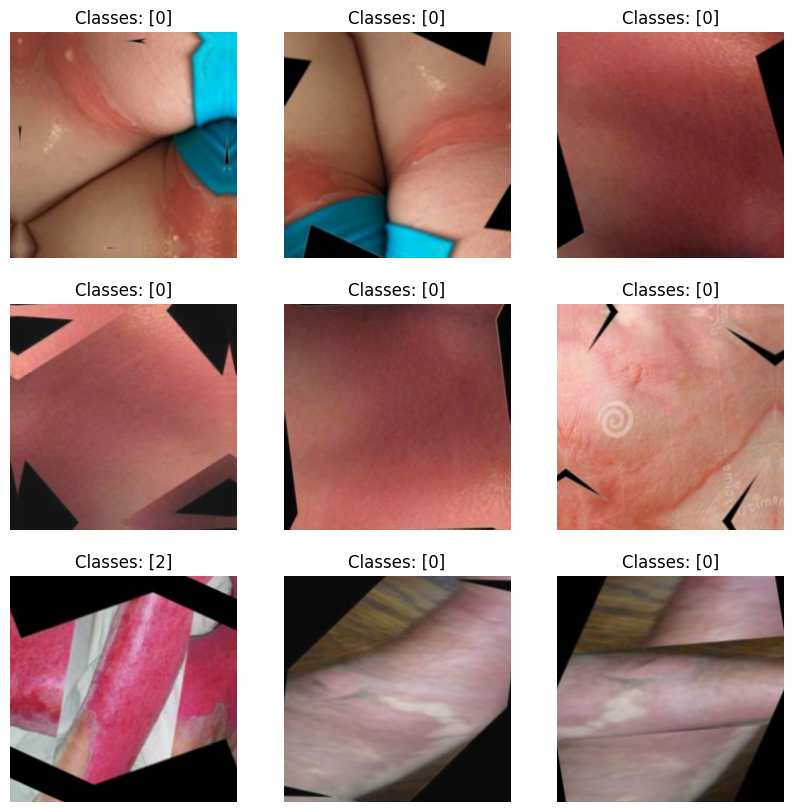

: 

In [ ]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy())
        plt.title(f"Classes: {labels['classes'][i].numpy()}")
        plt.axis("off")


In [ ]:
# 3.0 Build a finetunable CNN + Transformer model for burn classification
from keras.applications import ResNet50
from keras.layers import GlobalAveragePooling2D, Reshape, MultiHeadAttention, LayerNormalization, Dense, Dropout, Input, Flatten
from keras.models import Model
import tensorflow as tf

# 3.1 Load ResNet50 backbone (pretrained on ImageNet)
# Set trainable=False for initial training, then unfreeze for finetuning
base_cnn = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_cnn.trainable = False  # Freeze for now
print("ResNet50 backbone loaded. Trainable:", base_cnn.trainable)

# 3.2 Extract features
inputs = Input(shape=(224, 224, 3), name='input_image')
x = base_cnn(inputs, training=False)
print("Shape after CNN:", x.shape)

# 3.3 Global average pooling to flatten spatial dims
x = GlobalAveragePooling2D()(x)
print("Shape after GlobalAvePooling2D:", x.shape)

# 3.4 Reshape for transformer (batch, seq_len, features)
x = Reshape((1, -1))(x)  # (batch, 1, features)
print("Shape before transformer:", x.shape)

# 3.5 Simple Transformer block
x = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
x = LayerNormalization()(x)
print("Shape after transformer:", x.shape)

# 3.6 Flatten and dense layers for classification
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(3, activation='softmax', name='output_class')(x)

model = Model(inputs=inputs, outputs=outputs)

# Print model summary for debugging
print(model.summary())

# 3.7 Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
print("Model compiled.")

# 3.8 Example: Print a batch of labels to check shape
for images, labels in train_ds.take(1):
    print("Batch images shape:", images.shape)
    print("Batch labels shape:", labels['classes'].shape)
    print("Sample labels:", labels['classes'][:10].numpy())
    break

#  Ready for training! To finetune:
# - Train with base_cnn.trainable=False for a few epochs
# - Then set base_cnn.trainable=True, recompile with a lower lr, and continue training

# 3.9 Train the model (warm-up phase, CNN frozen)
EPOCHS = 1

def ds_for_classification(ds):
    return ds.map(lambda x, y: (x, y['classes']))

# Use these for training/validation
train_ds_cls = ds_for_classification(train_ds)
val_ds_cls = ds_for_classification(val_ds)

for x, y in train_ds_cls.take(1):
    print("Image batch shape:", x.shape)
    print("Label batch shape:", y.shape)
    print("Label sample:", y[:5].numpy())

history = model.fit(
    train_ds_cls,
    validation_data=val_ds_cls,
    epochs=EPOCHS
)


ResNet50 backbone loaded. Trainable: False
Shape after CNN: (None, 7, 7, 2048)
Shape after GlobalAvePooling2D: (None, 2048)
Shape before transformer: (None, 1, 2048)
Shape after transformer: (None, 1, 2048)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['input_image[0][0]']            
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['resnet50[0][0]']  

In [ ]:
# 4.0 Evaluate model performance and plot confusion matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Prepare test dataset for classification (extract class labels)
def ds_for_classification(ds):
    return ds.map(lambda x, y: (x, y['classes'][0] if len(y['classes'].shape) > 0 else y['classes']))

test_ds_cls = ds_for_classification(test_ds)

# Get predictions and true labels
all_preds = []
all_labels = []
for images, labels in test_ds_cls:
    preds = model.predict(images)
    pred_classes = np.argmax(preds, axis=1)
    all_preds.extend(pred_classes)
    all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["First Degree", "Second Degree", "Third Degree"]))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["First", "Second", "Third"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()